In [12]:
import cv2
import mediapipe as mp
import numpy as np
import time
from playsound import playsound
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

## Calculate Angles

In [13]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 


def calculate_angle_lateral(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
#     if angle >180.0:
#         angle = 360-angle
        
    return angle 

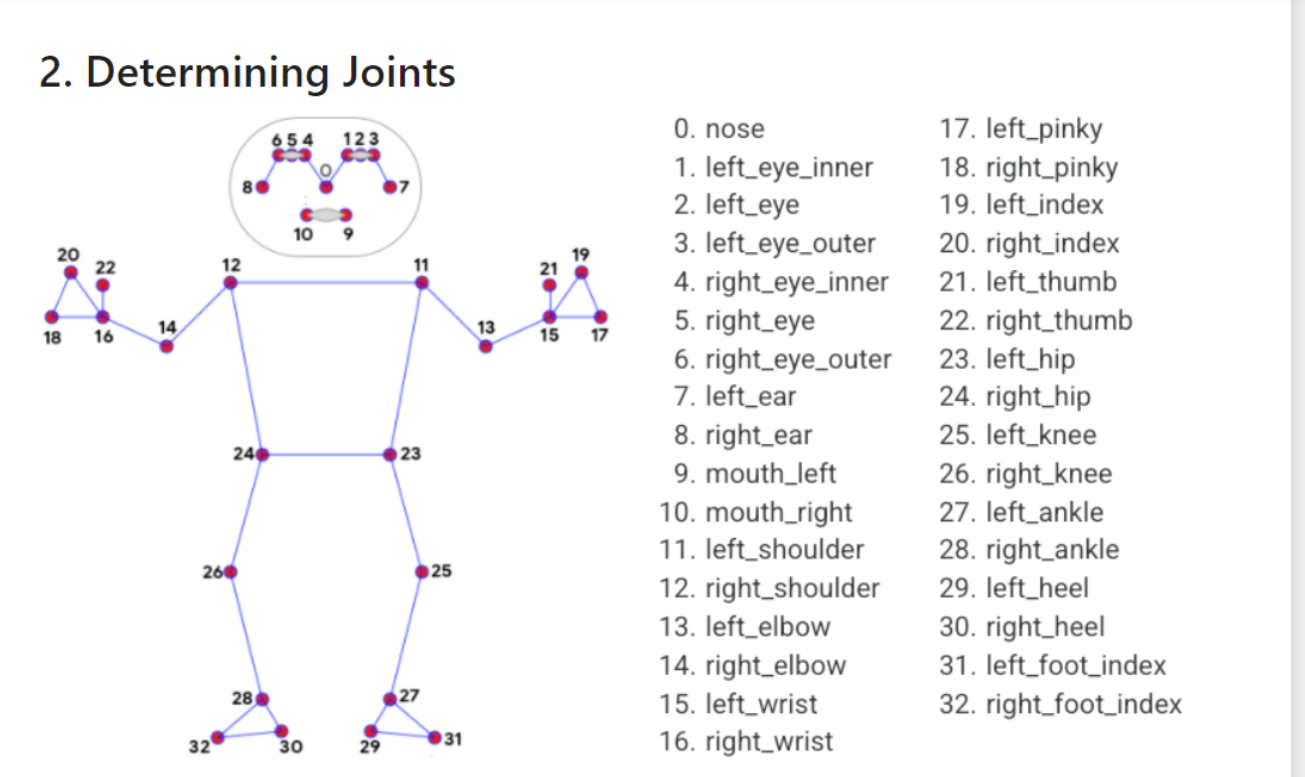

## Helper functions

In [14]:
def get_bounding_box(frame, margin = 0.15):
    delta = int(margin * frame.shape[1])
    
    bounding_box_normalised = {
        'x1' : delta/frame.shape[1],
        'y1' : 0,
        'x2' : (frame.shape[1] - delta) / frame.shape[1],
        'y2' : 1
    }
    
    return bounding_box_normalised


def add_bounding_box(frame, flag = 'out', margin = 0.15):
    mp = {
        'out' : (0, 0, 0),
        'in' : (255, 255, 255),
        'good' : (0, 255, 0),
        'bad' : (0, 0, 255)
    }
    
    color = mp[flag]
    
    # Allowing margin % 
    delta = int(margin * frame.shape[1])
    bounding_box = [(delta, 0), (frame.shape[1] - delta, frame.shape[0])]
    
    cv2.rectangle(frame, bounding_box[0], bounding_box[1], color, thickness = 2)
    
    return frame


def get_bounding_box_hori(frame, margin = 0.35):
    
    bounding_box_normalised = {
        'x1' : 0,
        'y1' : margin,
        'x2' : 1,
        'y2' : 1
    }
    
    return bounding_box_normalised


def add_bounding_box_hori(frame, flag = 'out', margin = 0.35):
    mp = {
        'out' : (0, 0, 0),
        'in' : (255, 255, 255),
        'good' : (0, 255, 0),
        'bad' : (0, 0, 255)
    }
    
    color = mp[flag]
    
    # Allowing margin % 
    bounding_box = [(0,int(margin * frame.shape[0])), (frame.shape[1], frame.shape[0])]
    
    cv2.rectangle(frame, bounding_box[0], bounding_box[1], color, thickness = 2)
    
    return frame


## Now we need to evaluate when flag turn true or false
## 1) if nose and both left and right hip lies in the bounding box we say 

def evaluate_flag(landmarks, bounding_box):
    nose = [landmarks[mp_pose.PoseLandmark.NOSE.value].x, landmarks[mp_pose.PoseLandmark.NOSE.value].y]
    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    visibility_right = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].visibility
    visibility_left = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].visibility
    visibility_nose = landmarks[mp_pose.PoseLandmark.NOSE.value].visibility
    visibility_left_ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].visibility
    visibility_right_ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].visibility
    
    flag = 'out'
    
    ## x is the horizontal normalised distance and y is the vertical normalise distance from (0, 0)
    if nose[0] >= bounding_box['x1'] and nose[0] <= bounding_box['x2'] and left_hip[0] >= bounding_box['x1'] and left_hip[0] <= bounding_box['x2'] and right_hip[0] >= bounding_box['x1'] and right_hip[0] <= bounding_box['x2'] and visibility_right >= 0.5 and visibility_left >= 0.5 and visibility_nose >= 0.5: 
        flag = 'in'
        
    return flag


def evaluate_flag_squats(landmarks, bounding_box):
    nose = [landmarks[mp_pose.PoseLandmark.NOSE.value].x, landmarks[mp_pose.PoseLandmark.NOSE.value].y]
    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    visibility_right = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].visibility
    visibility_left = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].visibility
    visibility_nose = landmarks[mp_pose.PoseLandmark.NOSE.value].visibility
    left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
    right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
    
    flag = 'out'
    
    ## x is the horizontal normalised distance and y is the vertical normalise distance from (0, 0)
    if nose[0] >= bounding_box['x1'] and nose[0] <= bounding_box['x2'] and left_hip[0] >= bounding_box['x1'] and left_hip[0] <= bounding_box['x2'] and right_hip[0] >= bounding_box['x1'] and right_hip[0] <= bounding_box['x2'] and visibility_right >= 0.5 and visibility_left >= 0.5 and visibility_nose >= 0.5 and left_ankle[0] >= bounding_box['x1'] and left_ankle[0] <= bounding_box['x2'] and right_ankle[0] >= bounding_box['x1'] and right_ankle[0] <= bounding_box['x2']: 
        flag = 'in'
        
    return flag


def evaluate_flag_pushups(landmarks, bounding_box):
    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    
    flag = 'out'
    
    ## x is the horizontal normalised distance and y is the vertical normalise distance from (0, 0) 
    #print(left_shoulder)
    
    if left_shoulder[1] >= bounding_box['y1'] and right_shoulder[1] >= bounding_box['y1']:
        flag = 'in'
        
    return flag


def add_info(frame, flag, params):
    ## Adding rectangle for Reps
    cv2.rectangle(frame, (0,0), (int(0.15 * 640)-2, 75), (135, 135, 88), -1)
    
    ## Adding rectangle for feedback
    cv2.rectangle(frame, (int(0.15 * 640) + 2, 2), (638 - int(0.15 * 640), 75), (135, 135, 88), -1)
    
    ## Adding one more rectangle
    cv2.rectangle(frame, (642 - int(0.15 * 640), 0), (640, 75), (135, 135, 88), -1)
    
    if flag == 'out':
        cv2.putText(frame, 'Come inside the Box', (130, 50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA
                                )
        
        if params['play_box'] == False:
            playsound('./come_inside_the_box.mp3')
            params['play_box'] = True
            params['box_timer'] = time.time()
        else:
            if time.time() - params['box_timer'] >= 4:
                playsound('./come_inside_the_box.mp3')
                params['box_timer'] = time.time()
        
#     elif flag == 'in':
#         cv2.putText(frame, 'Perform the exercise', (130, 50), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA
#                                 )
        
    return frame


def add_feedback(image, params):
    ## Adding rectangle for Reps
    cv2.rectangle(image, (0,0), (int(0.15 * 640)-2, 75), (135, 135, 88), -1)
    
    ## Adding rectangle for feedback
    cv2.rectangle(image, (int(0.15 * 640) + 2, 2), (638 - int(0.15 * 640), 75), (135, 135, 88), -1)
    
    ## Adding one more rectangle
    cv2.rectangle(image, (642 - int(0.15 * 640), 0), (640, 75), (135, 135, 88), -1)
    
    ## displaying reps
    cv2.putText(image, str(params['counter']), (10, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    ## displaying Exercise Name
    cv2.putText(image, str(params['name']), (546, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2, cv2.LINE_AA)
    
    ## Displaying if doing bad
    if time.time() - params['t1'] > 1.25 * params['threshtime'] and params['stage'] == 'down':
        image = add_bounding_box(image, flag = 'bad')
        cv2.putText(image, 'Raise your arms', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        ## Playing sound
        if params['error_flag'] == False:
            playsound("./raise_arms.mp3")
            params['error_timer'] = time.time()
            params['error_flag'] = True
        else:
            if time.time() - params['error_timer'] >= 1.25 * params['threshtime']:
                playsound('./raise_arms.mp3')
                params['error_timer'] = time.time()
        
    elif time.time() - params['t2'] > 1.25 * params['threshtime'] and params['stage'] == 'up':
        image = add_bounding_box(image, flag = 'bad')
        cv2.putText(image, 'Lower your arms', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
        
        ## Playing sound
        if params['error_flag'] == False:
            playsound('./lower_arms.mp3')
            params['error_timer'] = time.time()
            params['error_flag'] = True
        else:
            if time.time() - params['error_timer'] >= 1.25 * params['threshtime']:
                playsound('./lower_arms.mp3')
                params['error_timer'] = time.time()
                
    ### Displaying status after every n reps
    if params['counter'] % params['n_reps'] == 0 and params['counter'] >= params['n_reps']:
        if np.mean(params['times']) - params['threshtime'] > params['threshtime']/4:
            ## Add feedback for doing fast
            image = add_bounding_box(image, flag = 'bad')
            cv2.putText(image, 'Do Faster', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
            
        elif params['threshtime'] - np.mean(params['times']) > params['threshtime']/4:
            ## Add feedback for doing slow
            image = add_bounding_box(image, flag = 'bad')
            cv2.putText(image, 'Do slower', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
        
        ## 15% tolerance
        elif abs(params['threshtime'] - np.mean(params['times'])) <= 0.22 * params['threshtime']:
            ## Add good feedback
            image = add_bounding_box(image, flag = 'good')
            cv2.putText(image, 'Doing Good', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
                      
    return image


def add_feedback_squats(image, params):
    ## Adding rectangle for Reps
    cv2.rectangle(image, (0,0), (int(0.15 * 640)-2, 75), (135, 135, 88), -1)
    
    ## Adding rectangle for feedback
    cv2.rectangle(image, (int(0.15 * 640) + 2, 2), (638 - int(0.15 * 640), 75), (135, 135, 88), -1)
    
    ## Adding one more rectangle
    cv2.rectangle(image, (642 - int(0.15 * 640), 0), (640, 75), (135, 135, 88), -1)
    
    ## displaying reps
    cv2.putText(image, str(params['counter']), (10, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    ## displaying Exercise Name
    cv2.putText(image, str(params['name']), (546, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2, cv2.LINE_AA)
    
    ## Displaying if doing bad
    if time.time() - params['t1'] > 1.25 * params['threshtime'] and params['stage'] == 'up':
        image = add_bounding_box(image, flag = 'bad')
        cv2.putText(image, 'Go Down', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        ## Playing sound
        if params['error_flag'] == False:
            playsound("./go_down.mp3")
            params['error_timer'] = time.time()
            params['error_flag'] = True
        else:
            if time.time() - params['error_timer'] >= 1.25 * params['threshtime']:
                playsound('./go_down.mp3')
                params['error_timer'] = time.time()
        
    elif time.time() - params['t2'] > 1.25 * params['threshtime'] and params['stage'] == 'down':
        image = add_bounding_box(image, flag = 'bad')
        cv2.putText(image, 'Go up', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
        
        ## Playing sound
        if params['error_flag'] == False:
            playsound('./go_up.mp3')
            params['error_timer'] = time.time()
            params['error_flag'] = True
        else:
            if time.time() - params['error_timer'] >= 1.25 * params['threshtime']:
                playsound('./go_up.mp3')
                params['error_timer'] = time.time()
                
    ### Displaying status after every n reps
    if params['counter'] % params['n_reps'] == 0 and params['counter'] >= params['n_reps']:
        if np.mean(params['times']) - params['threshtime'] > params['threshtime']/4:
            ## Add feedback for doing fast
            image = add_bounding_box(image, flag = 'bad')
            cv2.putText(image, 'Do Faster', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
            
        elif params['threshtime'] - np.mean(params['times']) > params['threshtime']/4:
            ## Add feedback for doing slow
            image = add_bounding_box(image, flag = 'bad')
            cv2.putText(image, 'Do slower', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
        
        ## 15% tolerance
        elif abs(params['threshtime'] - np.mean(params['times'])) <= 0.22 * params['threshtime']:
            ## Add good feedback
            image = add_bounding_box(image, flag = 'good')
            cv2.putText(image, 'Doing Good', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
                      
    return image



def check_time(params):
    colors = []
    for x in params['rep_time_list']:
        if x >= 1.25 * params['threshtime']:
            colors.append('red')
        elif x <= 0.75 * params['threshtime']:
            colors.append('blue')
        else:
            colors.append('green')
    
    return colors
            

def plot(params):
    ## getting color for different points
    col = check_time(params)

    plt.figure(figsize = (15, 4))
    plt.grid()
    plt.plot(range(1, params['counter']+1), params['rep_time_list'], 'y-.')

    for i in range(len(params['rep_time_list'])):
        plt.scatter(i+1, params['rep_time_list'][i],c = col[i], s = 70,
                    linewidth = 0)

    plt.xticks(list(range(1, params['counter']+1)))
    plt.xlabel('Reps')
    plt.ylabel('Rep time')
    plt.title(params['name'])

    plt.text(params['counter']-4, max(params['rep_time_list'])-0.5,'Good Rep',
             fontsize = 13, bbox = dict(facecolor = 'green', alpha = 0.5))

    plt.text(params['counter']-2.5, max(params['rep_time_list'])-0.5,'Slow Rep',
             fontsize = 13, bbox = dict(facecolor = 'red', alpha = 0.5))

    plt.text(params['counter']-1.1, max(params['rep_time_list'])-0.5,'Fast Rep',
             fontsize = 13, bbox = dict(facecolor = 'blue', alpha = 0.5))
    
    try:
        plt.text(params['counter']-4, max(params['rep_time_list'])-1, 'Max Angle: ' + str(int(params['max_angle'])),
             fontsize = 13, bbox = dict(facecolor = 'yellow', alpha = 0.5))
        
        plt.text(params['counter']-2.5, max(params['rep_time_list'])-1, 'Min Angle: ' + str(int(params['min_angle'])),
             fontsize = 13, bbox = dict(facecolor = 'yellow', alpha = 0.5))
    except:
        pass
    
    plt.show()


### Elbow Flexion

In [15]:
def elbowFlexion(image, landmarks, params):
    params['name'] = 'Elbow Flexion'
    
    # Get coordinates
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
    left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
    right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
    
    # Calculate angle
    angle_left = calculate_angle(left_shoulder, left_elbow, left_wrist)
    angle_right = calculate_angle(right_shoulder, right_elbow, right_wrist)
    angle = np.round((angle_left + angle_right)/2)
    
    # displaying angle in the frame
    cv2.putText(image, str(int(angle_left)), 
                           tuple(np.multiply(left_elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
    cv2.putText(image, str(int(angle_right)), 
                           tuple(np.multiply(right_elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
    
    ## Counter logic
    
    if angle > 160 and (params['stage'] is None or params['stage'] == 'up'):
        if params['stage'] == 'up':
            params['times'][(params['counter']-1) % params['n_reps']] = abs(time.time() - params['t1'])
            params['rep_time'] = abs(time.time() - params['t1'])
            params['rep_time_list'].append(params['rep_time'])
            
        params['t1'] = time.time()
        
    if angle > 160:
        params['stage'] = 'down'
        params['max_angle'] = max(params['max_angle'], angle)
        
    if angle < 38 and params['stage'] == 'down':
        params['stage'] = 'up'
        params['counter'] += 1
        params['t2'] = time.time()
        
    if angle < 38:
        params['min_angle'] = min(params['min_angle'], angle)
        
        ## Error Calculation
    
    
    return image, params

### Squats

In [16]:
def squats(image, landmarks, params):
    params['name'] = 'Squats'
    
    # Get coordinates
    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
    
    # Calculate angle
    angle_left = calculate_angle(left_hip, left_knee, left_ankle)
    angle_right = calculate_angle(right_hip, right_knee, right_ankle)
    angle = np.round((angle_left + angle_right)/2)
    
    # displaying angle in the frame
    cv2.putText(image, str(int(angle_left)), 
                           tuple(np.multiply(left_knee, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
    cv2.putText(image, str(int(angle_right)), 
                           tuple(np.multiply(right_knee, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
    
    ## Counter logic
    
    if angle > 160 and (params['stage'] is None or params['stage'] == 'down'):
        if params['stage'] == 'down':
            params['times'][(params['counter']-1) % params['n_reps']] = abs(time.time() - params['t1'])
            params['rep_time'] = abs(time.time() - params['t1'])
            params['rep_time_list'].append(params['rep_time'])
            
        params['t1'] = time.time()
        
    if angle > 160:
        params['stage'] = 'up'
        
    if angle < 70 and params['stage'] == 'up':
        params['stage'] = 'down'
        params['counter'] += 1
        params['t2'] = time.time()
        
        ## Error Calculation
    
    
    return image, params

## Pushups

In [16]:
def pushups(image, landmarks, params):
    params['name'] = 'Pushups'
    
    # Get coordinates
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
    left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
    right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
    right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
    left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    
    # Calculate angle
    angle_left = calculate_angle(left_shoulder, left_elbow, left_wrist)
    angle_right = calculate_angle(right_shoulder, right_elbow, right_wrist)
    angle = np.round((angle_left + angle_right)/2)
    
    angle_pos_left = calculate_angle(left_hip, left_knee, left_ankle)
    angle_pos_right = calculate_angle(right_hip, right_knee, right_ankle)
    angle_pos = np.round((angle_pos_left + angle_pos_right)/2)
    
    # displaying angle in the frame
    cv2.putText(image, str(int(angle_left)), 
                           tuple(np.multiply(left_elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
    cv2.putText(image, str(int(angle_right)), 
                           tuple(np.multiply(right_elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
    cv2.putText(image, str(int(angle_pos)), 
                           tuple(np.multiply(right_knee, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
    
    ## Counter logic
    
    if angle_pos >= 70:
        if angle > 160 and (params['stage'] is None or params['stage'] == 'down'):
            if params['stage'] == 'down':
                params['times'][(params['counter']-1) % params['n_reps']] = abs(time.time() - params['t1'])
                params['rep_time'] = abs(time.time() - params['t1'])
                params['rep_time_list'].append(params['rep_time'])

            params['t1'] = time.time()

        if angle > 160:
            params['stage'] = 'up'

        if angle < 77 and params['stage'] == 'up':
            params['stage'] = 'down'
            params['counter'] += 1
            params['t2'] = time.time()
            
    else:
        cv2.putText(image, 'Straighten your posture', (130, 50), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)

        ## Error Calculation
        
    ### Error ogic
    
    
    
    return image, params

### Exercise Code
1) Elbow Flexion

ValueError: max() arg is an empty sequence

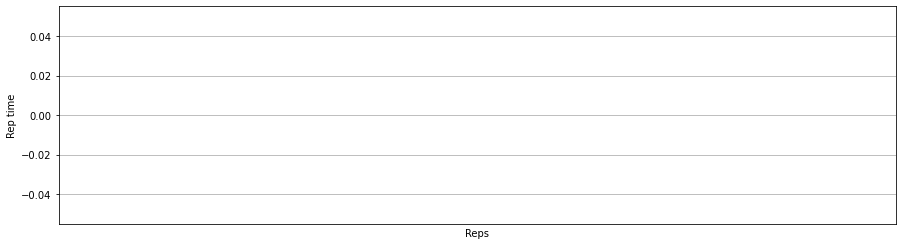

In [6]:
cap = cv2.VideoCapture(0)

params = {
    'counter' : 0,
    'stage' : None,
    't1' : time.time(),
    't2' : time.time(),
    'curr_timer' : time.time(),
    'threshtime' : 2.5,
    'times' : [0] * 4,
    'feedback' : None,
    'rep_time' : None,
    'name' : None,
    'error_timer' : None,
    'error_flag' : False,
    'play_box' : False,
    'box_timer':None,
    'n_reps' : 4,
    'error' : 0,
    'rep_time_list': [],
    'max_angle' : 0,
    'min_angle' : 180
}

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (640, 480))
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # get_bounding box
        bounding_box = get_bounding_box(image)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Storing curr time
            params['curr_timer'] = time.time()
            
            # evaluate flag
            flag = evaluate_flag(landmarks, bounding_box)
            
            # add bounding box
            image = add_bounding_box(image, flag = flag)
            
            # add information bar
            image = add_info(image, flag, params)
            
            # elbow Flexion
            # This function is only called when flag == in
            if flag == 'in':
                params['inside'] = True
                image, params = elbowFlexion(image, landmarks, params)
                image = add_feedback(image, params)
            else:
                params['inside'] = False
            
        except:
            image = add_bounding_box(image, flag = 'out')
            image = add_info(image, 'out', params)
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=1), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            

    cap.release()
    cv2.destroyAllWindows()
    

plot(params)

### Squats

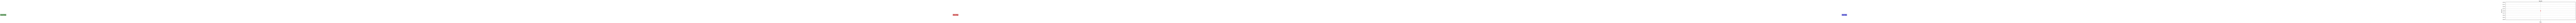

In [18]:
cap = cv2.VideoCapture(0)

params = {
    'counter' : 0,
    'stage' : None,
    't1' : time.time(),
    't2' : time.time(),
    'curr_timer' : time.time(),
    'threshtime' : 4,
    'times' : [0] * 4,
    'feedback' : None,
    'rep_time' : None,
    'name' : None,
    'error_timer' : None,
    'error_flag' : False,
    'play_box' : False,
    'box_timer':None,
    'n_reps' : 3,
    'error' : 0,
    'rep_time_list': []
}

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (640, 480))
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # get_bounding box
        bounding_box = get_bounding_box(image)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Storing curr time
            params['curr_timer'] = time.time()
            
            # evaluate flag
            flag = evaluate_flag_squats(landmarks, bounding_box)
            
            # add bounding box
            image = add_bounding_box(image, flag = flag)
            
            # add information bar
            image = add_info(image, flag, params)
            
            # elbow Flexion
            # This function is only called when flag == in
            if flag == 'in':
                params['inside'] = True
                image, params = squats(image, landmarks, params)
                image = add_feedback_squats(image, params)
            else:
                params['inside'] = False
            
        except:
            image = add_bounding_box(image, flag = 'out')
            image = add_info(image, 'out', params)
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=1), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            

    cap.release()
    cv2.destroyAllWindows()
    

plot(params)


### Pushups

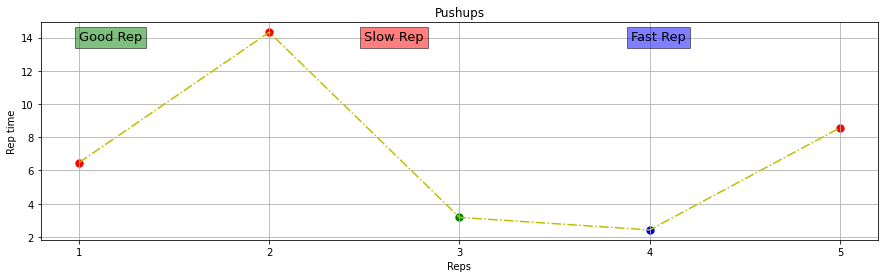

In [18]:
cap = cv2.VideoCapture(0)

params = {
    'counter' : 0,
    'stage' : None,
    't1' : time.time(),
    't2' : time.time(),
    'curr_timer' : time.time(),
    'threshtime' : 4,
    'times' : [0] * 3,
    'feedback' : None,
    'rep_time' : None,
    'name' : None,
    'error_timer' : None,
    'error_flag' : False,
    'play_box' : False,
    'box_timer':None,
    'n_reps' : 3,
    'error' : 0,
    'rep_time_list': []
}

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # get_bounding box
        bounding_box = get_bounding_box_hori(image)
        #print(bounding_box)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            #print(landmarks)
            
            # Storing curr time
            params['curr_timer'] = time.time()
            
            # evaluate flag
            flag = evaluate_flag_pushups(landmarks, bounding_box)

            # add bounding box
            
            image = add_bounding_box_hori(image, flag = flag)
            
            
            # add information bar
            image = add_info(image, flag, params)
            
            
            # elbow Flexion
            # This function is only called when flag == in
            if flag == 'in':
                params['inside'] = True
                image, params = pushups(image, landmarks, params)
                image = add_feedback_squats(image, params)
            else:
                params['inside'] = False
            
        except:
            #print('YES')
            image = add_bounding_box_hori(image, flag = 'out')
            image = add_info(image, 'out', params)
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=1), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            

    cap.release()
    cv2.destroyAllWindows()
    

plot(params)


In [19]:
# get_bounding_box_hori()

In [30]:
# def lateral_flexion():
cap = cv2.VideoCapture(0)

# curl counter variables
counter = 0 
stage = None
t1 = t2 = time.time()
curr_timer = time.time()
threshtime = 4
times = [0] * 4
feedback = None
rep_time = None
min_angle_left = 360
max_angle_left = 0
min_angle_right = 360
max_angle_right = 0

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        # Coloring BGR -> RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 

        # Extract Landmarks
        try:
            # Storing curr time
            curr_timer = time.time()

            landmarks = results.pose_landmarks.landmark

            # Get Coordinates
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

            # Calculate angle
            angle_left = calculate_angle(left_knee, left_hip, left_shoulder)
            angle_right = calculate_angle(right_knee, right_hip, right_shoulder)

            #Visualize angle
            cv2.putText(image, str(int(angle_left)), 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )

            cv2.putText(image, str(int(angle_right)), 
                           tuple(np.multiply(right_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )


            #print(angle)


            # Curl counter logic
            if angle_left < 165:
                stage = 'left'
                max_angle_left = max(max_angle_left, angle_left)

            elif angle_right < 165:
                stage = 'right'
                max_angle_right = max(max_angle_right, angle_right)

            elif abs(angle_left - angle_right) < 15:
                if stage == 'left':
                    stage = 'right'  
                else:
                    stage = 'left'
            
            
            
#                 if angle < 170 and (stage == None or stage == 'right'):
#                     if stage == 'right':
#                         t2 = time.time()
#                         times[(counter-1)%4] = abs(t2-t1)
#                         rep_time = abs(t2-t1)    
#                     t1 = time.time()


#                 if angle < 170:
#                     stage = 'left'

#                 if angle > 200 and stage == 'left':
#                     stage = 'right'
#                     counter += 1

#                 #print(counter)


        except:
            pass

        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0,0), (640,73), (245,117,16), -1)

        # Rep data
#             cv2.putText(image, 'REPS', (15,12), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
#             cv2.putText(image, str(counter), 
#                         (10,60), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

        # Stage data
        cv2.putText(image, 'STAGE', (140,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (120,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

        ## Time Data
#             cv2.putText(image, 'REP TIME', (300, 12),
#                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

#             cv2.putText(image, str(rep_time)[0:4], 
#                         (300,60), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

        ## Feedback 
#             cv2.putText(image, 'FEEDBACK', (500, 12),
#                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

#             if counter % 4 == 0 and counter != 0:
#                 if (np.mean(times) - threshtime) > threshtime/4:
#                     feedback = 'Do Fast'
#                 elif (threshtime - np.mean(times)) > threshtime/4:
#                     feedback = 'Do slow'
#                 else:
#                     feedback = 'Doing good'

#             elif abs(curr_timer-t1) > 3.5: # if curr time - prev rep > 3 we say 
#                 if stage == 'left':
#                     feedback = 'Bend rightwards'
#                 else:
#                     feedback = 'Bend leftwards'

#             else:
#                 feedback = None

#             cv2.putText(image, feedback, 
#                         (450,60), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)



        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1) 
                                 )               

        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    
    print(max_angle_left)
    print(max_angle_right)

164.98813237778688
164.36957684174084


In [29]:
165 - 90

75

In [33]:
# def lateral_flexion():
cap = cv2.VideoCapture(0)

# curl counter variables
counter = 0 
stage = None
t1 = t2 = time.time()
curr_timer = time.time()
threshtime = 4
times = [0] * 4
feedback = None
rep_time = None
min_angle = 180
max_angle = 0

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        # Coloring BGR -> RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 

        # Extract Landmarks
        try:
            # Storing curr time
            curr_timer = time.time()

            landmarks = results.pose_landmarks.landmark

            # Get Coordinates
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

            # Calculate angle
            angle_left = calculate_angle(left_ankle, left_hip, left_shoulder)
            angle_right = calculate_angle(right_ankle, right_hip, right_shoulder)
            angle = 0.5 * (angle_left + angle_right)
            
            #Visualize angle
            cv2.putText(image, str(int(angle_left)), 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )

            cv2.putText(image, str(int(angle_right)), 
                           tuple(np.multiply(right_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            
            
            
            if angle > 160 and (stage == None or stage == 'down'):
                if stage == 'down':
                    t2 = time.time()
                    times[(counter-1)%4] = abs(t2-t1)
                    rep_time = abs(t2-t1)    
                t1 = time.time()


            if angle > 160:
                stage = 'up'
                max_angle = max(angle, max_angle)

            if angle < 88 and stage == 'up':
                stage = 'down'
                counter += 1
                min_angle = min(angle, min_angle)

            #print(counter)


        except:
            pass

        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0,0), (640,73), (245,117,16), -1)

        #Rep data
        cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

        # Stage data
        cv2.putText(image, 'STAGE', (140,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (120,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

        ## Time Data
#             cv2.putText(image, 'REP TIME', (300, 12),
#                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

#             cv2.putText(image, str(rep_time)[0:4], 
#                         (300,60), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

        ## Feedback 
#             cv2.putText(image, 'FEEDBACK', (500, 12),
#                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

#             if counter % 4 == 0 and counter != 0:
#                 if (np.mean(times) - threshtime) > threshtime/4:
#                     feedback = 'Do Fast'
#                 elif (threshtime - np.mean(times)) > threshtime/4:
#                     feedback = 'Do slow'
#                 else:
#                     feedback = 'Doing good'

#             elif abs(curr_timer-t1) > 3.5: # if curr time - prev rep > 3 we say 
#                 if stage == 'left':
#                     feedback = 'Bend rightwards'
#                 else:
#                     feedback = 'Bend leftwards'

#             else:
#                 feedback = None

#             cv2.putText(image, feedback, 
#                         (450,60), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)



        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1) 
                                 )               

        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    
    print(max_angle_left)
    print(max_angle_right)

164.98813237778688
164.36957684174084


In [34]:
min_angle

75.17908446323446

In [35]:
max_angle

179.10929756341443